## Packages and configuration

In [3]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import pprint
import numpy as np

## Load Competiton, Match, and Event Data from statsbombpy

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Call statsbombpy API to get all free competitions, then chec Women's comps
free_comps = sb.competitions()
women_comps = free_comps[free_comps['competition_gender'] == 'female']
women_comps

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
25,37,90,England,FA Women's Super League,female,False,False,2020/2021,2025-04-23T14:16:46.924831,2021-06-13T16:17:31.694,None,2025-04-23T14:16:46.924831
26,37,42,England,FA Women's Super League,female,False,False,2019/2020,2024-02-12T15:05:34.211400,2021-06-13T16:17:31.694,None,2024-02-12T15:05:34.211400
27,37,4,England,FA Women's Super League,female,False,False,2018/2019,2024-08-07T17:22:40.334287,2021-06-13T16:17:31.694,None,2024-08-07T17:22:40.334287
63,49,3,United States of America,NWSL,female,False,False,2018,2024-12-15T12:31:48.035735,2021-06-13T16:17:31.694,None,2024-12-15T12:31:48.035735
71,53,315,Europe,UEFA Women's Euro,female,False,True,2025,2025-07-28T14:19:20.467348,2025-07-29T16:03:07.355174,2025-07-29T16:03:07.355174,2025-07-28T14:19:20.467348
72,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2024-02-13T13:27:17.178263,2024-02-13T13:30:52.820588,2024-02-13T13:30:52.820588,2024-02-13T13:27:17.178263
73,72,107,International,Women's World Cup,female,False,True,2023,2025-07-14T10:07:06.620906,2025-07-14T10:10:27.224586,2025-07-14T10:10:27.224586,2025-07-14T10:07:06.620906
74,72,30,International,Women's World Cup,female,False,True,2019,2024-08-08T15:57:56.748740,2021-06-13T16:17:31.694,None,2024-08-08T15:57:56.748740


## All women's matches

In [5]:
all_matches = []

for _, row in women_comps.iterrows():
    matches = sb.matches(
        competition_id=row["competition_id"],
        season_id=row["season_id"]
    )
    all_matches.append(matches)

matches_df = pd.concat(all_matches, ignore_index=True)

In [10]:
len(matches_df)

540

## All events, passes only

In [13]:
from pathlib import Path
import pandas as pd

CACHE_DIR = Path("statsbomb_cache/events")
CACHE_DIR.mkdir(parents=True, exist_ok=True)


def load_events(match_id):
    cache_file = CACHE_DIR / f"{match_id}.parquet"

    if cache_file.exists():
        return pd.read_parquet(cache_file)

    events = sb.events(match_id=match_id)
    events.to_parquet(cache_file)
    return events

In [14]:
all_passes = []

for match_id in matches_df["match_id"]:
    events = load_events(match_id)
    passes = events[events["type"] == "Pass"]
    all_passes.append(passes)

passes_df = pd.concat(all_passes, ignore_index=True)

In [17]:
len(passes_df)

496100

In [18]:
passes_df.head(2)

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_punched_out,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,dribble_overrun,injury_stoppage_in_chain,clearance_other,goalkeeper_shot_saved_off_target,shot_deflected,shot_saved_off_target,foul_committed_offensive,foul_committed_penalty,foul_won_penalty,miscontrol_aerial_won,shot_redirect,ball_recovery_offensive,block_save_block,goalkeeper_success_in_play,bad_behaviour_card,dribble_no_touch,shot_follows_dribble,goalkeeper_saved_to_post,half_start_late_video_start,goalkeeper_shot_saved_to_post,shot_saved_to_post,goalkeeper_lost_out,goalkeeper_lost_in_play,half_end_early_video_end,pass_backheel,player_off_permanent,goalkeeper_success_out,goalkeeper_penalty_saved_to_post,shot_kick_off
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.311672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4c33f2eb-7392-419d-b6ac-bedaa573ddc6,5,NaN,"[61.0, 40.1]",3775648,0,NaN,NaN,NaN,1.144169,NaN,Right Foot,NaN,NaN,NaN,"[62.0, 42.3]",NaN,Ground Pass,NaN,2.416609,NaN,NaN,NaN,NaN,Bethany Mead,15619.0,NaN,NaN,NaN,NaN,NaN,Kick Off,1,From Kick Off,Vivianne Miedema,15623.0,Left Wing,2,Arsenal WFC,968,[a2016066-fbb9-4d5a-8f6b-2f9d7411a4dd],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arsenal WFC,968,00:00:00.340,Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.125058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4467e274-205f-41be-ab7e-62ece2697dbc,8,NaN,"[59.3, 40.8]",3775648,0,NaN,NaN,NaN,-3.089616,NaN,Right Foot,NaN,NaN,NaN,"[42.0, 39.9]",NaN,Ground Pass,NaN,17.323395,NaN,NaN,NaN,NaN,Lia Wälti,10405.0,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,Bethany Mead,15619.0,Center Forward,2,Arsenal WFC,968,[0e9e4a0c-46ea-4aea-9c62-b4883bf1d993],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arsenal WFC,968,00:00:00.692,Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
passes_df["play_pattern"].unique()

array(['From Kick Off', 'Regular Play', 'From Keeper', 'From Free Kick',
       'From Throw In', 'From Corner', 'From Counter', 'From Goal Kick',
       'Other'], dtype=object)

## Check pass positions

In [55]:
df = passes_df.copy()

PITCH_LENGTH = 120
PITCH_WIDTH = 80

# Extract coordinates
df["start_x"] = df["location"].str[0]
df["start_y"] = df["location"].str[1]
df["end_x"] = df["pass_end_location"].str[0]
df["end_y"] = df["pass_end_location"].str[1]

# Start location checks
start_outside = df[
    (df["start_x"] < 0) | (df["start_x"] > PITCH_LENGTH) |
    (df["start_y"] < 0) | (df["start_y"] > PITCH_WIDTH)
]

# End (reception) location checks
end_outside = df[
    (df["end_x"] < 0) | (df["end_x"] > PITCH_LENGTH) |
    (df["end_y"] < 0) | (df["end_y"] > PITCH_WIDTH)
]

print(f"Start locations outside pitch: {len(start_outside)}")
print(f"End locations outside pitch: {len(end_outside)}")

Start locations outside pitch: 10
End locations outside pitch: 41


In [56]:
start_outside[[
    "start_x",
    "start_y",
    "team",
    "player",
    "play_pattern",
    "pass_type",
    "pass_outcome"
]].sort_values(["start_x", "start_y"])

,start_x,start_y,team,player,play_pattern,pass_type,pass_outcome
153125,21.8,80.2,Brighton & Hove Albion WFC,Matilde Lundorf Skovsen,From Throw In,NaN,NaN
177719,30.4,80.2,Bristol City WFC,Loren Dykes,From Throw In,NaN,NaN
175716,44.6,80.1,Liverpool WFC,Melissa Lawley,From Throw In,NaN,Incomplete
171959,50.4,80.2,West Ham United LFC,Kate Longhurst,Regular Play,NaN,NaN
175906,54.9,80.1,Liverpool WFC,Rebecca Jane,From Goal Kick,NaN,Incomplete
175754,58.6,80.2,Liverpool WFC,Rebecca Jane,From Throw In,NaN,NaN
175905,60.0,80.1,Liverpool WFC,Jessica Anne Clarke,From Goal Kick,NaN,NaN
175931,71.7,80.2,Liverpool WFC,Rebecca Jane,From Throw In,NaN,NaN
175686,74.5,80.2,Liverpool WFC,Rebecca Jane,From Throw In,NaN,NaN
171517,120.4,27.5,West Ham United LFC,Kate Longhurst,From Throw In,NaN,Out


In [57]:
end_outside[[
    "end_x",
    "end_y",
    "team",
    "player",
    "play_pattern",
    "pass_type",
    "pass_outcome"
]].sort_values(["end_x", "end_y"])

,end_x,end_y,team,player,play_pattern,pass_type,pass_outcome
171483,10.1,80.9,West Ham United LFC,Laura Vetterlein,From Throw In,NaN,Out
172280,11.8,80.9,Arsenal WFC,Leah Williamson,From Free Kick,NaN,Out
177871,47.0,80.9,Bristol City WFC,Yana Daniëls,Regular Play,NaN,Out
171958,50.4,80.2,West Ham United LFC,Gilly Louise Scarlett Flaherty,Regular Play,NaN,NaN
175871,50.4,80.9,Liverpool WFC,Leigh-Anne Robe,From Free Kick,NaN,Out
175905,55.2,80.1,Liverpool WFC,Jessica Anne Clarke,From Goal Kick,NaN,NaN
176099,58.6,80.9,Liverpool WFC,Rebecca Jane,Regular Play,Recovery,Out
175385,66.0,80.9,Tottenham Hotspur Women,Hannah Godfrey,Regular Play,NaN,Out
177824,70.8,80.9,Bristol City WFC,Sophie Baggaley,From Keeper,NaN,Injury Clearance
171764,73.3,80.9,West Ham United LFC,Kenza Dali,Regular Play,NaN,Out


### Pass start position

In [31]:
df["completed"] = df["pass_outcome"].isna().astype(int)

In [32]:
# Define pitch bins (10-yard grid)
x_bins = np.linspace(0, 120, 13)
y_bins = np.linspace(0, 80, 9)

df["x_zone"] = pd.cut(df["start_x"], bins=x_bins, labels=False)
df["y_zone"] = pd.cut(df["start_y"], bins=y_bins, labels=False)

In [33]:
zone_stats = (
    df
    .groupby(["x_zone", "y_zone"])
    .agg(
        passes=("completed", "count"),
        completion_rate=("completed", "mean")
    )
    .reset_index()
)

In [37]:
zone_stats = zone_stats[zone_stats["passes"] >= 20]

In [38]:
completion_grid = zone_stats.pivot(
    index="y_zone",
    columns="x_zone",
    values="completion_rate"
)

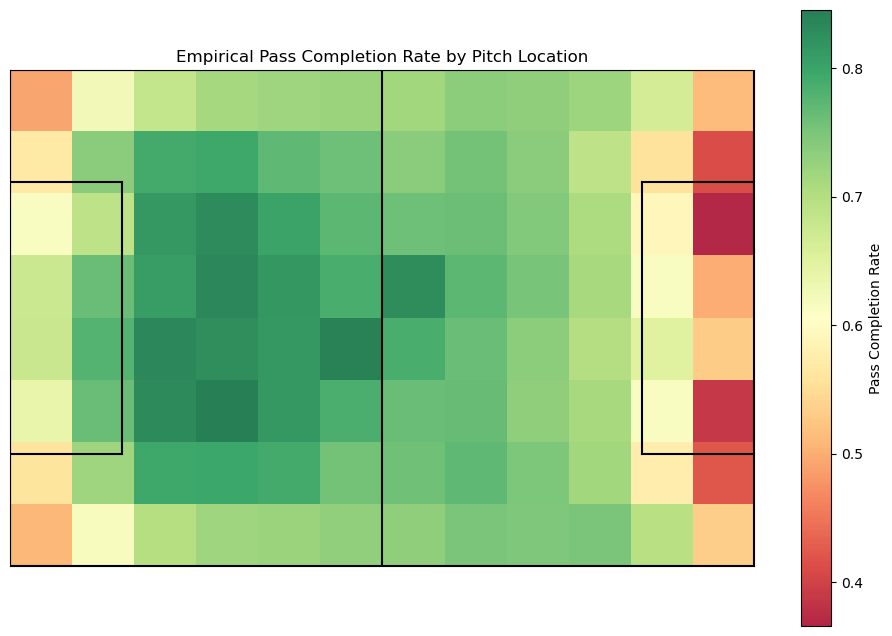

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Pitch outline
ax.plot([0, 120, 120, 0, 0], [0, 0, 80, 80, 0], color="black")
ax.plot([60, 60], [0, 80], color="black")

# Penalty areas
ax.plot([102, 120], [18, 18], color="black")
ax.plot([102, 102], [18, 62], color="black")
ax.plot([102, 120], [62, 62], color="black")

ax.plot([0, 18], [18, 18], color="black")
ax.plot([18, 18], [18, 62], color="black")
ax.plot([0, 18], [62, 62], color="black")

# Heatmap of completion rate
im = ax.imshow(
    completion_grid.values,
    extent=[0, 120, 0, 80],
    origin="lower",
    cmap="RdYlGn",
    alpha=0.85
)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Pass Completion Rate")

# Formatting
ax.set_title("Empirical Pass Completion Rate by Pitch Location")
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")

plt.show()

### Pass reception position

In [50]:
# Define pitch bins (10-yard grid)
x_bins = np.linspace(0, 120, 13)
y_bins = np.linspace(0, 80, 9)

df["x_zone"] = pd.cut(df["end_x"], bins=x_bins, labels=False)
df["y_zone"] = pd.cut(df["end_y"], bins=y_bins, labels=False)

In [51]:
zone_stats = (
    df
    .groupby(["x_zone", "y_zone"])
    .agg(
        passes=("completed", "count"),
        completion_rate=("completed", "mean")
    )
    .reset_index()
)

In [52]:
zone_stats = zone_stats[zone_stats["passes"] >= 20]

In [53]:
completion_grid = zone_stats.pivot(
    index="y_zone",
    columns="x_zone",
    values="completion_rate"
)

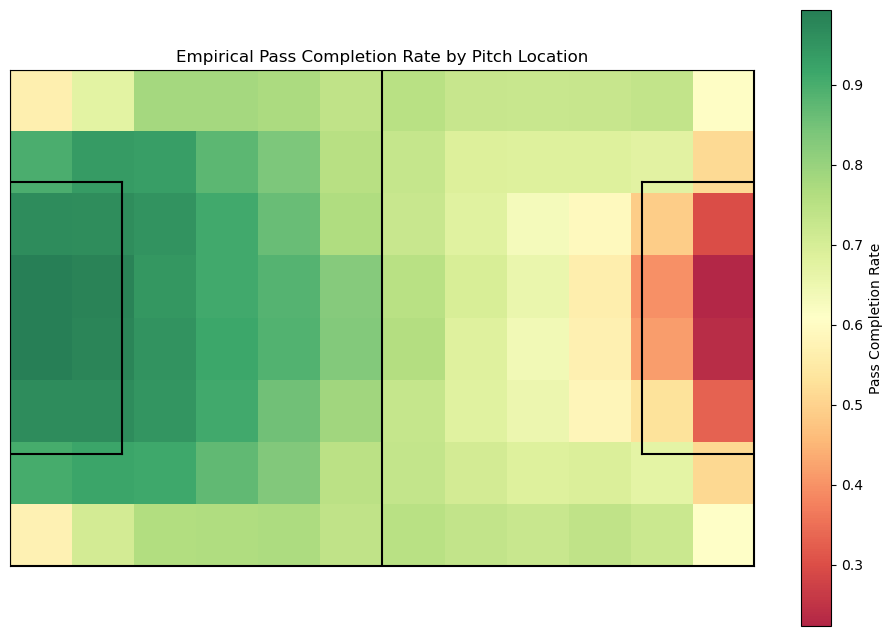

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Pitch outline
ax.plot([0, 120, 120, 0, 0], [0, 0, 80, 80, 0], color="black")
ax.plot([60, 60], [0, 80], color="black")

# Penalty areas
ax.plot([102, 120], [18, 18], color="black")
ax.plot([102, 102], [18, 62], color="black")
ax.plot([102, 120], [62, 62], color="black")

ax.plot([0, 18], [18, 18], color="black")
ax.plot([18, 18], [18, 62], color="black")
ax.plot([0, 18], [62, 62], color="black")

# Heatmap of completion rate
im = ax.imshow(
    completion_grid.values,
    extent=[0, 120, 0, 80],
    origin="lower",
    cmap="RdYlGn",
    alpha=0.85
)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Pass Completion Rate")

# Formatting
ax.set_title("Empirical Pass Completion Rate by Pitch Location")
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")

plt.show()

## Feature engineering

In [27]:
df = passes_df.copy()

# Pitch is fixed in StatsBomb (always attacking left → right)
PITCH_LENGTH = 120
PITCH_WIDTH = 80
GOAL_X = PITCH_LENGTH
GOAL_Y = PITCH_WIDTH / 2


# Extract start / end locations
df["start_x"] = df["location"].str[0]
df["start_y"] = df["location"].str[1]
df["end_x"] = df["pass_end_location"].str[0]
df["end_y"] = df["pass_end_location"].str[1]


# Straight-line pass length (basic geometry)
df["pass_distance"] = np.sqrt(
    (df["end_x"] - df["start_x"])**2 +
    (df["end_y"] - df["start_y"])**2
)

# Distance from the ball to the opponent's goal
# (smaller distance = denser space, usually harder)
df["start_dist_goal"] = np.sqrt(
    (GOAL_X - df["start_x"])**2 +
    (GOAL_Y - df["start_y"])**2
)

df["end_dist_goal"] = np.sqrt(
    (GOAL_X - df["end_x"])**2 +
    (GOAL_Y - df["end_y"])**2
)

# How much closer the pass moves the ball towards goal
df["progression"] = df["start_dist_goal"] - df["end_dist_goal"]

# Common heuristic: >10 yards closer to goal = progressive
df["progressive"] = (df["progression"] > 10).astype(int)


# Pitch zones

# Own half vs opposition half
df["start_opp_half"] = (df["start_x"] >= PITCH_LENGTH / 2).astype(int)
df["end_opp_half"] = (df["end_x"] >= PITCH_LENGTH / 2).astype(int)

# Central corridor (roughly middle third of pitch width)
df["start_central"] = (
    (df["start_y"] > PITCH_WIDTH * 0.33) &
    (df["start_y"] < PITCH_WIDTH * 0.67)
).astype(int)

df["end_central"] = (
    (df["end_y"] > PITCH_WIDTH * 0.33) &
    (df["end_y"] < PITCH_WIDTH * 0.67)
).astype(int)


# Whether the passer was under defensive pressure
df["under_pressure"] = (
    df["under_pressure"]
    .fillna(False)
    .astype(bool)
    .astype(int)
)

# High balls are generally harder to control and receive
df["high_pass"] = (df["pass_height"] == "High Pass").astype(int)

# Pass intent / type indicators
df["through_ball"] = (
    df["pass_through_ball"]
    .fillna(False)
    .astype(bool)
    .astype(int)
)

df["cross"] = (
    df["pass_cross"]
    .fillna(False)
    .astype(bool)
    .astype(int)
)

df["switch"] = (
    df["pass_switch"]
    .fillna(False)
    .astype(bool)
    .astype(int)
)


# Combined difficulty features

# Long passes under pressure
df["long_pass"] = (df["pass_distance"] > 25).astype(int)
df["very_long_pass"] = (df["pass_distance"] > 40).astype(int)
df["long_under_pressure"] = df["long_pass"] * df["under_pressure"]

# Progressive passes in the opposition half
df["progressive_opp_half"] = df["progressive"] * df["start_opp_half"]

# Crosses under pressure
df["cross_under_pressure"] = df["cross"] * df["under_pressure"]

# Central progressive passes
df["central_progressive"] = df["progressive"] * df["start_central"]


# Play pattern context
# Regular Play is the baseline and will be dropped
play_pattern_dummies = pd.get_dummies(
    df["play_pattern"],
    prefix="pp",
    drop_first=True
)

df = pd.concat([df, play_pattern_dummies], axis=1)


# COMPLETED PASSES
df["completed"] = df["pass_outcome"].isna().astype(int)


# Final feature list for xP model
# (no raw x/y, only football-meaningful variables)
FEATURES = [
    "pass_distance",
    "progression",
    "start_dist_goal",
    "start_opp_half",
    "start_central",
    "under_pressure",
    "high_pass",
    "through_ball",
    "cross",
    "switch",
    "long_under_pressure",
    "very_long_pass",
    "progressive_opp_half",
    "cross_under_pressure",
    "central_progressive",
]

# Explicitly add play pattern one-hot features
FEATURES += list(play_pattern_dummies.columns)

X = df[FEATURES]
y = df["completed"]

C:\Users\vicky\AppData\Local\Temp\ipykernel_24572\2063795305.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
C:\Users\vicky\AppData\Local\Temp\ipykernel_24572\2063795305.py:74: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
C:\Users\vicky\AppData\Local\Temp\ipykernel_24572\2063795305.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.n

## Train global xP model

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# --------------------------------------------------
# Fit expected pass completion (xP) model
# --------------------------------------------------

# Simple logistic regression is enough here.
# The goal is interpretability, not squeezing every last % of performance.
model = LogisticRegression(max_iter=1000)

model.fit(X, y)

# --------------------------------------------------
# Check coefficients to see if they make football sense
# --------------------------------------------------

coef_table = pd.DataFrame({
    "feature": FEATURES,
    "coef": model.coef_[0]
}).sort_values("coef")

coef_table

,feature,coef
6,high_pass,-1.200202
8,cross,-0.900407
11,very_long_pass,-0.750838
7,through_ball,-0.611860
5,under_pressure,-0.536529
21,pp_Other,-0.372252
9,switch,-0.369800
17,pp_From Goal Kick,-0.369690
10,long_under_pressure,-0.302895
19,pp_From Kick Off,-0.299176


In [29]:
# --------------------------------------------------
# Generate expected completion probability (xP)
# --------------------------------------------------

df["xP"] = model.predict_proba(X)[:, 1]

# Basic discrimination check
auc = roc_auc_score(y, df["xP"])
print(f"AUC: {auc:.3f}")


AUC: 0.833
